In [1]:
import kaggle
import pandas as pd
import numpy as np
import zipfile
from datetime import datetime
import matplotlib.pyplot as plt
from IPython.display import display
import sys

In [8]:
!kaggle competitions download -c sbermarket-internship-competition


  0%|          | 0.00/11.5M [00:00<?, ?B/s]
  9%|8         | 1.00M/11.5M [00:00<00:01, 7.45MB/s]
 17%|#7        | 2.00M/11.5M [00:00<00:01, 7.79MB/s]
 35%|###4      | 4.00M/11.5M [00:00<00:00, 8.42MB/s]
 52%|#####2    | 6.00M/11.5M [00:00<00:00, 9.86MB/s]
 70%|######9   | 8.00M/11.5M [00:00<00:00, 9.65MB/s]
 87%|########7 | 10.0M/11.5M [00:01<00:00, 10.0MB/s]
100%|##########| 11.5M/11.5M [00:01<00:00, 10.9MB/s]


In [2]:
zf = zipfile.ZipFile('sbermarket-internship-competition.zip')

In [3]:
test_df = pd.read_csv(zf.open('train.csv'), index_col = 'order_completed_at', parse_dates=True)
test_df.head()

,user_id,cart
order_completed_at,,
2015-03-22 09:25:46,2,399
2015-03-22 09:25:46,2,14
2015-03-22 09:25:46,2,198
2015-03-22 09:25:46,2,88
2015-03-22 09:25:46,2,157


In [296]:
norders = test_df.reset_index().groupby('user_id').agg({'order_completed_at': 'nunique', 'cart': 'nunique'})
display(norders.head(8)) # таблица количества заказов и количества товаров, когда либо заказанных для каждого user_id
norders.describe()

,order_completed_at,cart
user_id,,
0,3,36
1,9,20
2,15,74
3,7,38
4,8,50
5,15,76
6,10,42
7,11,59


,order_completed_at,cart
count,20000.000000,20000.000000
mean,10.470300,55.880000
std,11.905856,32.057291
min,3.000000,1.000000
25%,4.000000,33.000000
50%,6.000000,49.000000
75%,12.000000,73.000000
max,213.000000,250.000000


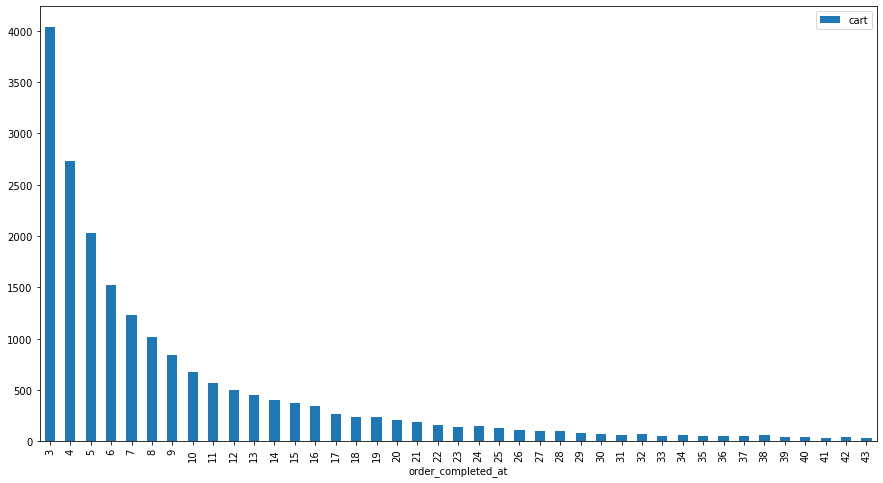

In [357]:
Q95 = norders['order_completed_at'].quantile(0.975)
dist_ord = norders[norders['order_completed_at'] <= Q95].groupby('order_completed_at').count()
dist_ord.plot(kind = 'bar', figsize = (15, 8));

In [554]:
idx = norders.idxmax()[0] # user_id  человека, сделавшего наибольшее количество заказов
idx

2196

In [555]:
for_idx = test_df[test_df.user_id == idx].pivot_table(columns = 'cart', # сводная таблица для даты заказа и продукта
                                          index = test_df[test_df.user_id == idx].index, 
                                          aggfunc = 'count', fill_value = 0)
for_idx.columns = for_idx.columns.map(lambda x: x[1])
for_idx

,0,5,6,9,14,17,19,22,23,24,...,434,692,741,744,804,805,806,807,812,846
order_completed_at,,,,,,,,,,,,,,,,,,,,,
2019-07-27 07:48:07,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2019-07-28 18:59:20,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-08-29 08:16:44,0,0,0,0,1,1,0,0,1,1,...,0,0,0,0,1,0,0,0,0,0
2019-08-30 22:02:02,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2019-10-03 19:48:02,0,0,0,1,1,1,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-19 23:28:05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-07-21 05:46:29,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-07-22 08:03:39,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


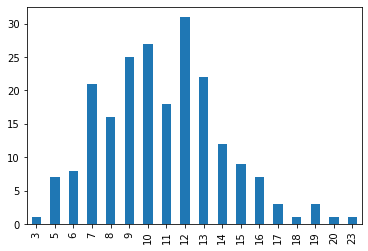

In [556]:
for_idx.sum(axis = 1).groupby(for_idx.sum(axis = 1).values).count().plot(kind = 'bar'); # распределение количества товаров в заказе

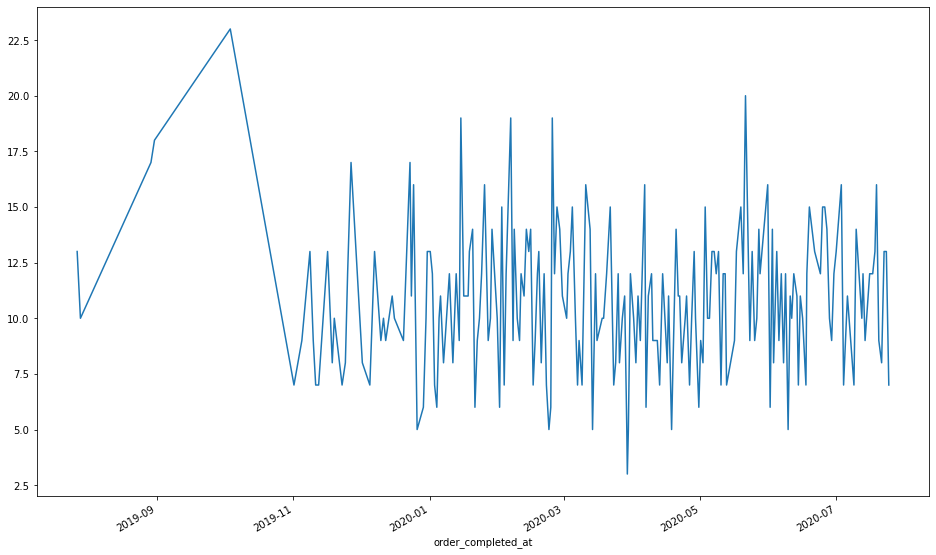

In [557]:
orders = for_idx.sum(axis = 1)
orders.plot(figsize = (16, 10));

In [558]:
betta = 0.8 # формула Надаррая - Ватсона для экспоненциального скользящего среднего
pred = sum(np.array([betta**i for i in range(len(orders)-1, -1, -1)]) * orders.values)/sum(np.array([betta**i for i in range(len(orders)-1, -1, -1)]))
pred = int(round(pred))
print(f'прогноз на количество продуктов в следующем заказе - {round(pred)}')

прогноз на количество продуктов в следующем заказе - 11


In [559]:
stat = orders.describe()
stat

count    213.000000
mean      10.779343
std        3.245192
min        3.000000
25%        9.000000
50%       11.000000
75%       13.000000
max       23.000000
dtype: float64

In [560]:
# самые популярные товары
freq_prod = for_idx.sum()
most_pop = freq_prod[freq_prod >= freq_prod.nlargest(pred).values[-1]].sort_values(ascending = False)
most_pop

57     196
432    177
430    152
431    145
420    111
171    105
24      98
385     96
25      86
92      84
170     82
dtype: int64

In [561]:
n = 10 # смотрим последние 10 заказов user_id, определяем самые популярные товары последних заказов 
last_ord = for_idx.iloc[-n:, :].sum()
last_pop = last_ord[last_ord >= last_ord.nlargest(pred).values[-1]].sort_values(ascending = False)
last_pop

57     10
433     9
430     9
432     8
431     6
385     5
171     5
61      5
25      5
14      5
394     4
170     4
24      4
dtype: int64

In [562]:
res = pd.concat([freq_prod, last_ord], axis = 1)
res.columns = ['prev', 'last']
res['metric'] = res['prev'] - res['last'] + res['last']**1.6 
res.nlargest(pred, 'metric')

,prev,last,metric
57,196,10,225.810717
432,177,8,196.857618
430,152,9,176.634735
431,145,6,156.580936
420,111,3,113.799546
171,105,5,113.132639
385,96,5,104.132639
24,98,4,103.189587
25,86,5,94.132639
170,82,4,87.189587


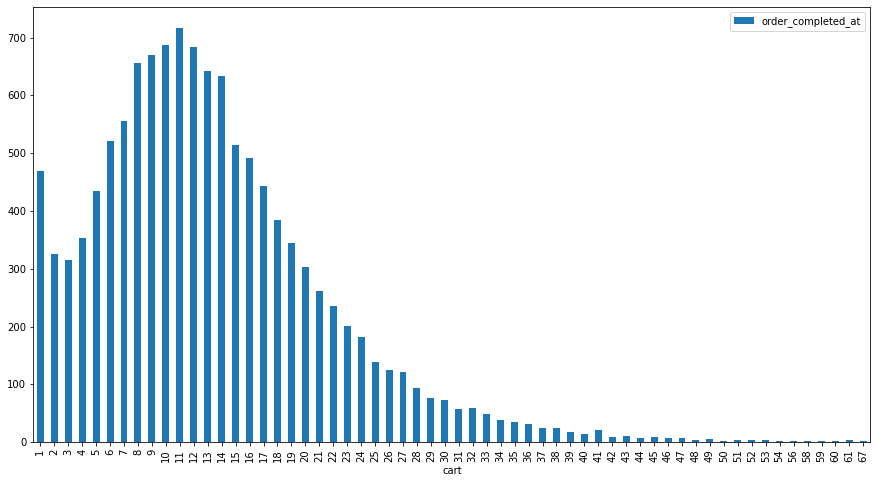

In [392]:
n = 3 # распределение числа товаров в заказе для пользователей, сделавших n заказов
group_ord = test_df[test_df.user_id.isin(norders[norders['order_completed_at'] == n].index)]
group_ord.groupby(group_ord.index).agg({'cart': 'count'}).reset_index().groupby('cart').count().plot(kind = 'bar', figsize = (15, 8));

In [11]:
# теперь основная функция
def def_products (inp):
    user = inp[0]
    df = inp[1]
    pers = df.pivot_table(columns = 'cart', # сводная таблица для даты заказа и продукта
                                          index = df.index, 
                                          aggfunc = 'count', fill_value = 0)
    pers.columns = pers.columns.map(lambda x: x[1])
    n_orders = pers.shape[0]
    dict_ord = {}
    for i in range(8, 61):
        dict_ord[i] = int(i*0.25) + round(i % 1 + sys.float_info.epsilon)
    if n_orders in dict_ord:
        n_last = dict_ord[n_orders]
    elif n_orders > 60:
        n_last = 15
    else:
        n_last = False
    orders = pers.sum(axis = 1)
    # определяем коэффициент betta для формулы: чем больше заказов - тем выше betta
    betta = 1/185 * n_orders + 149/235
    if betta > 0.9:
        betta = 0.9
    # формула Надаррая - Ватсона для экспоненциального скользящего среднего, определяем количество продуктов в следующем заказе
    N = sum(np.array([betta**i for i in range(len(orders)-1, -1, -1)]) * orders.values)/sum(np.array([betta**i for i in range(len(orders)-1, -1, -1)]))
    N = int(N) + int(round(N % 1))
    freq_prod = pers.sum()
    if n_last:
        last_ord = pers.iloc[-n_last:, :].sum()
        freq_prod -= last_ord
        res = pd.concat([freq_prod, last_ord], axis = 1)
        res.columns = ['prev', 'last']
        res['metric'] = res['prev'] + res['last']**1.6 # придаем количеству последних заказов продукта больший вес
        order = res.nlargest(N, 'metric').index # здесь итоговый состав заказа
    else:
        res = freq_prod
        order = res.nlargest(N).index
    ans = pd.DataFrame({0: res.index, 1: res.index.isin(order).astype(int)})
    ans.index = [user] * ans.shape[0]
    return(ans)

In [12]:
predict = pd.concat(list(map(lambda x: def_products(x), list(test_df.groupby('user_id')))))

In [13]:
col = list(map(lambda x, y: x+y, list(map(lambda x: str(x)+';', predict.index)), list(map(lambda x: str(x), predict[0]))))
for_kaggle = pd.DataFrame({'id': col, 'target': predict[1]}).reset_index(drop = True)
for_kaggle.head(10)

,id,target
0,0;5,1
1,0;10,1
2,0;14,1
3,0;20,1
4,0;22,1
5,0;25,1
6,0;26,1
7,0;41,1
8,0;55,1
9,0;57,1


In [14]:
sample = pd.DataFrame(pd.read_csv(zf.open('sample_submission.csv'))['id'])
sample

,id
0,0;133
1,0;5
2,0;10
3,0;396
4,0;14
...,...
790444,19998;26
790445,19998;31
790446,19998;29
790447,19998;798


In [15]:
for_kaggle = sample.merge(for_kaggle, on = 'id')
for_kaggle.to_csv(r'C:\Users\DNS\Desktop\predict_2.csv', index = False, header=True)